# Bikes: Variable importance with different $m$

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

In [2]:
RANDOM_SEED = 4579
np.random.seed(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

## Biking with BART

In [3]:
bikes = pd.read_csv("bikes.csv")

X = bikes[["hour", "temperature", "humidity", "windspeed"]]
Y = bikes["count"]

In [4]:
trees = [20, 50, 100]
idatas_bikes = {}
VIs = []

In [5]:
for m in trees:
    with pm.Model() as model_bikes:
        α = pm.Exponential("α", 0.1)
        μ_ = pmb.BART("μ_", X, np.log(Y), m=m)
        μ = pm.Deterministic("μ", np.exp(μ_))
        y = pm.NegativeBinomial("y", mu=μ, alpha=α, observed=Y)
        idata = pm.sample(tune=2000, draws=2000, chains=4, random_seed=RANDOM_SEED)
        idatas_bikes[str(m)] = idata
        # Variable importance
        VI = idata.sample_stats["variable_inclusion"].mean(("chain", "draw")).values
        VIs.append(VI / VI.sum())

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 71 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 166 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 323 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


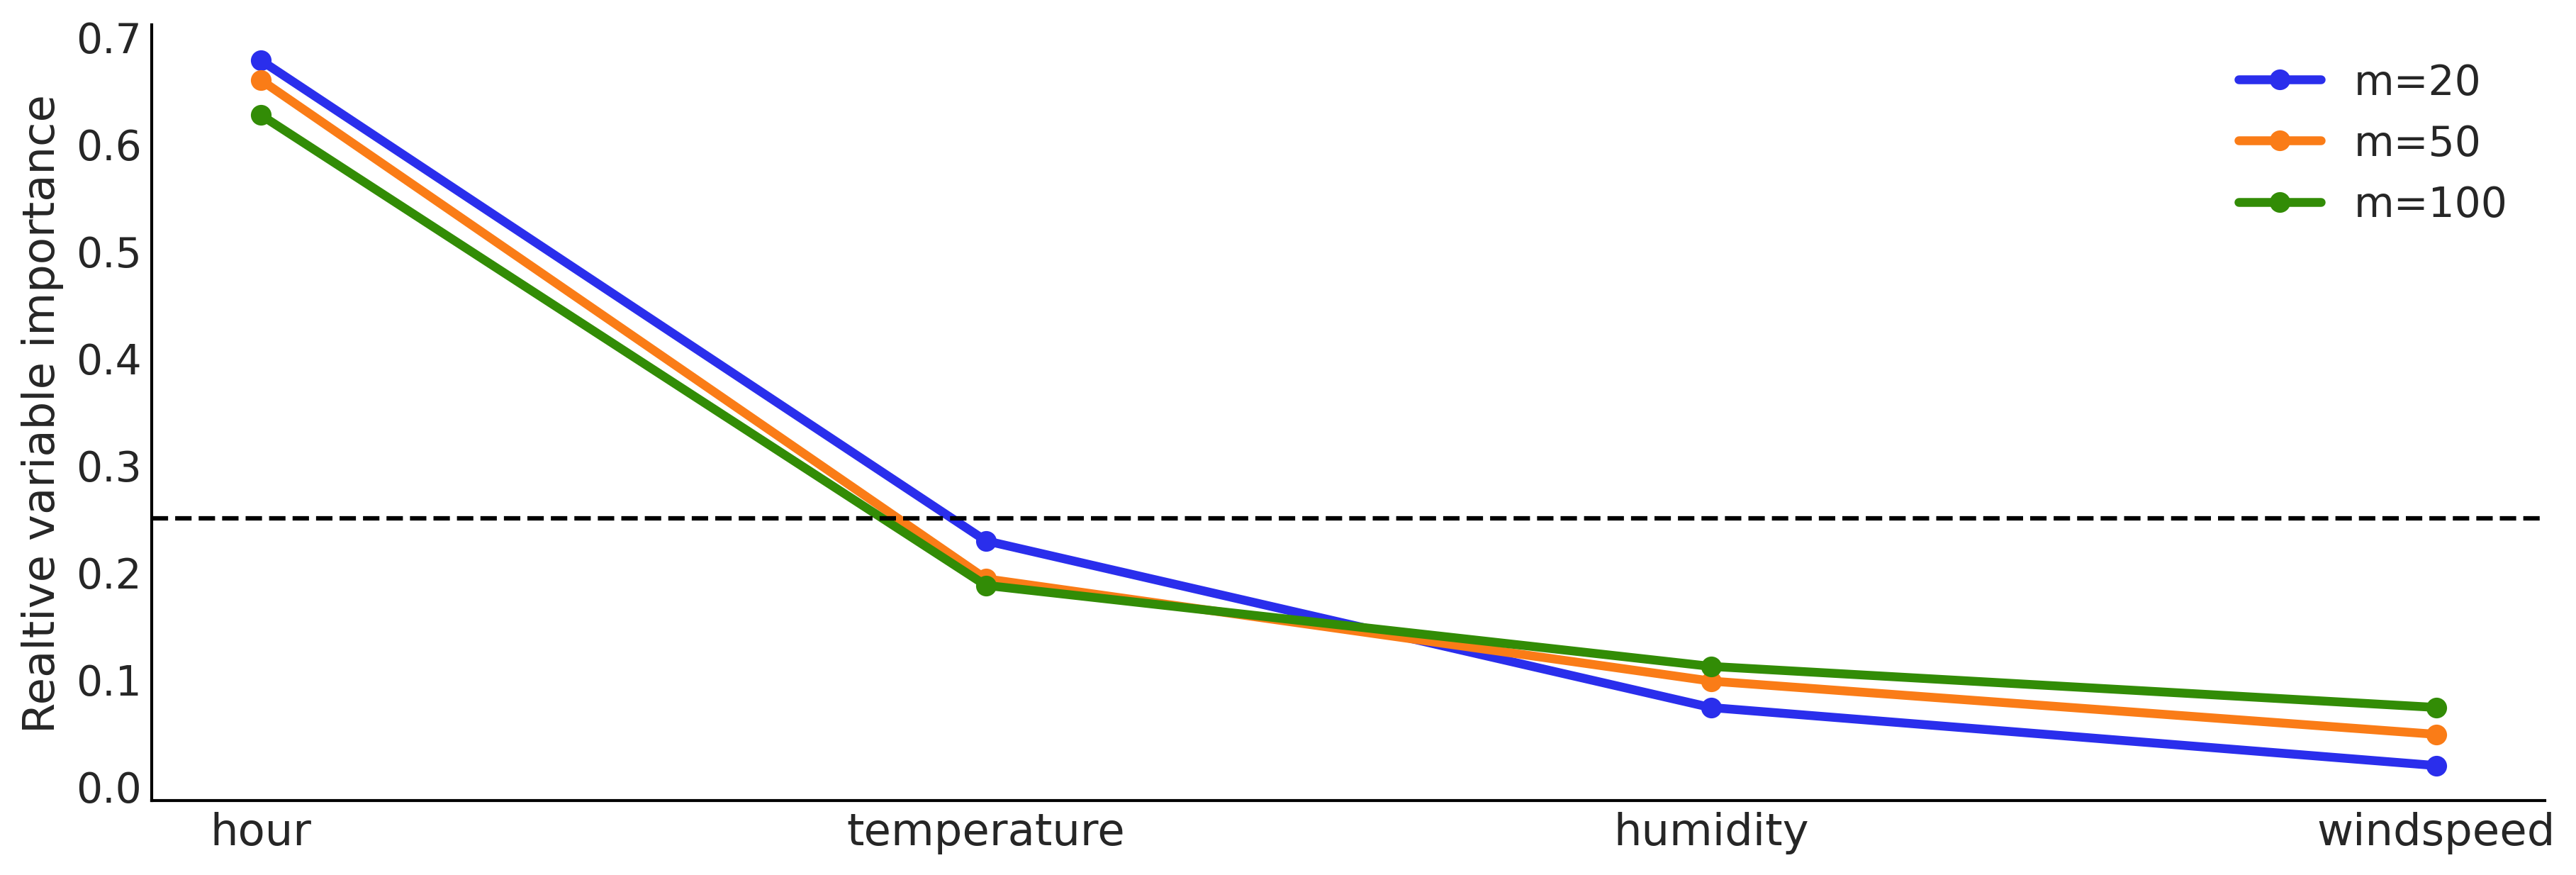

In [6]:
fig, ax = plt.subplots(sharey=True, figsize=(12, 4))

for tree, vi in zip(trees, VIs):
    plt.plot(vi, label=f"m={tree}", lw=3, marker="o")

plt.axhline(1 / X.shape[1], ls="--", color="k")

plt.legend()
plt.ylabel("Realtive variable importance")
plt.xticks(
    ticks=list(range(X.shape[1])), labels=[label for label in X.columns], fontsize=15
)

plt.savefig("bart_vi_bikes.png");